# Microproyecto 4

EQUIPO 6

JUAN DAVID PINO RAMÍREZ - 1000407196 - jpinor@unal.edu.co

SEBASTIÁN LÓPEZ MAZO - 1001774362 - selopez@unal.edu.co

JULIÁN ESTEBAN CARVAJAL RAMÍREZ - 10001774262 - jucarvajalr@unal.edu.co



Este microproyecto clasifica 50 especies de mariposas mediante una red neuronal convolucional de clasificación.


## Imports

Se debe importar el archivo kaggle.json el cual es el token de activación para poder consumir el servicio de la API de Kaggle.

In [1]:
#Importe de librerías
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import math
import os
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
# scikit-image
from skimage import io 
from skimage.transform import rescale, resize, downscale_local_mean
from random import randint, choice, choices
from tensorflow import keras
from PIL import Image

In [ ]:
#Intalación kaggle
#!pip install  -q kaggle

In [ ]:
#Importe token activación de kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sebastianlopezmazo","key":"1c010af59e76877a98a4756884ec3d06"}'}

In [ ]:
#Creación del directorio kaggle
! mkdir ~/.kaggle

In [ ]:
#Copia del token de activación
! cp kaggle.json ~/.kaggle/

In [ ]:
#Listado de datasets de kaggle
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-01 17:39:01          13165  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7934  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3465  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           3052  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [ ]:
#Importe del dataset mariposas
! kaggle datasets download -d gpiosenka/butterfly-images40-species

100% 838M/842M [00:26<00:00, 57.0MB/s]
100% 842M/842M [00:26<00:00, 33.6MB/s]


In [ ]:
#Descompresión
!unzip butterfly-images40-species.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: butterflies_rev2/train/an 88/05.jpg  
  inflating: butterflies_rev2/train/an 88/06.jpg  
  inflating: butterflies_rev2/train/an 88/07.jpg  
  inflating: butterflies_rev2/train/an 88/08.jpg  
  inflating: butterflies_rev2/train/an 88/09.jpg  
  inflating: butterflies_rev2/train/an 88/10.jpg  
  inflating: butterflies_rev2/train/an 88/11.jpg  
  inflating: butterflies_rev2/train/an 88/12.jpg  
  inflating: butterflies_rev2/train/an 88/13.jpg  
  inflating: butterflies_rev2/train/an 88/14.jpg  
  inflating: butterflies_rev2/train/an 88/15.jpg  
  inflating: butterflies_rev2/train/an 88/16.jpg  
  inflating: butterflies_rev2/train/an 88/17.jpg  
  inflating: butterflies_rev2/train/an 88/18.jpg  
  inflating: butterflies_rev2/train/an 88/19.jpg  
  inflating: butterflies_rev2/train/an 88/20.jpg  
  inflating: butterflies_rev2/train/an 88/21.jpg  
  inflating: butterflies_rev2/train/an 88/22.jpg  
  inflating: butterfl


## Función carga de imágenes 

In [ ]:
#Diccionario de clases
clases = {
  'adonis':0,
  'american snoot' :1,
  'an 88' :2,
  'banded peacock' :3,
  'beckers white' :4,
  'black hairstreak' :5,
  'cabbage white' :6,
  'chestnut' :7,
  'clodius parnassian' :8,
  'clouded sulphur' :9,
  'copper tail' :10,
  'crecent' :11,
  'crimson patch' :12,
  'eastern coma' :13,
  'gold banded' :14,
  'great eggfly' :15,
  'grey hairstreak' :16,
  'indra swallow' :17,
  'julia' :18,
  'large marble' :19,
  'malachite' :20,
  'mangrove skipper' :21,
  'metalmark' :22,
  'monarch' :23,
  'morning cloak' :24,
  'orange oakleaf' :25,
  'orange tip' :26,
  'orchard swallow' :27,
  'painted lady' :28,
  'paper kite' :29,
  'peacock' :30,
  'pine white'  :31,
  'pipevine swallow' :32,
  'purple hairstreak' :33,
  'question mark' :34,
  'red admiral' :35,
  'red spotted purple' :36,
  'scarce swallow' :37,
  'silver spot skipper' :38,
  'sixspot burnet' :39,
  'skipper' :40,
  'sootywing' :41,
  'southern dogface' :42,
  'straited queen' :43,
  'two barred flasher' :44,
  'ulyses' :45,
  'viceroy' :46,
  'wood satyr' :47,
  'yellow swallow tail' :48,
  'zebra long wing' :49
}

In [ ]:
#Funcion carga de imágenes en arrays

def load_images(dir_name, claseslist):  
    train = []
    test = []
    valid = []
    labels_train = []
    labels_train_long = []
    labels_test = []
    labels_test_long = []
    labels_valid = []

    for label in claseslist:
        with os.scandir(os.path.join(os.path.join(dir_name, 'train'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_train.append(label)
          labels_train_long.append(os.path.join(label, archive))
          train.append(io.imread(os.path.join(os.path.join(dir_name, 'train'), os.path.join(label, archive))))
        with os.scandir(os.path.join(os.path.join(dir_name, 'test'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_test.append(label)
          labels_test_long.append(os.path.join(label, archive))
          test.append(io.imread(os.path.join(os.path.join(dir_name, 'test'), os.path.join(label, archive))))
        with os.scandir(os.path.join(os.path.join(dir_name, 'valid'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_valid.append(label)
          valid.append(io.imread(os.path.join(os.path.join(dir_name, 'valid'), os.path.join(label, archive))))

    return train, test, valid, labels_train, labels_train_long, labels_test, labels_test_long, labels_valid

## Selección de clases.

In [ ]:
# N: número de clases que se desean usar (1-50)
N = 50

# Toma las primeras N clases
# claseslist = [key for key in clases.keys()][:N]

# Toma N clases aleatorias
claseslist = []
while(len(claseslist)<N):
  clase = choice([key for key in clases.keys()])
  if clase not in claseslist:
    claseslist.append(clase)
claseslist.sort()

pd.DataFrame(claseslist, columns=['Labels'])

Labels
0                adonis
1        american snoot
2                 an 88
3        banded peacock
4         beckers white
5      black hairstreak
6         cabbage white
7              chestnut
8    clodius parnassian
9       clouded sulphur
10          copper tail
11              crecent
12        crimson patch
13         eastern coma
14          gold banded
15         great eggfly
16      grey hairstreak
17        indra swallow
18                julia
19         large marble
20            malachite
21     mangrove skipper
22            metalmark
23              monarch
24        morning cloak
25       orange oakleaf
26           orange tip
27      orchard swallow
28         painted lady
29           paper kite
30              peacock
31           pine white
32     pipevine swallow
33    purple hairstreak
34        question mark
35          red admiral
36   red spotted purple
37       scarce swallow
38  silver spot skipper
39       sixspot burnet
40              skipper
41            sootywing
42     southern dogface
43       straited queen
44   two barred flasher
45               ulyses
46              viceroy
47           wood satyr
48  yellow swallow tail
49      zebra long wing

## Carga de imágenes

In [ ]:
train, test, valid, labels_train, labels_train_long, labels_test, labels_test_long, labels_valid = load_images('butterflies', claseslist)

In [ ]:
print(len(train))
print(len(test))
print(len(valid))

4955
250
250


## Vista previa de las imágenes

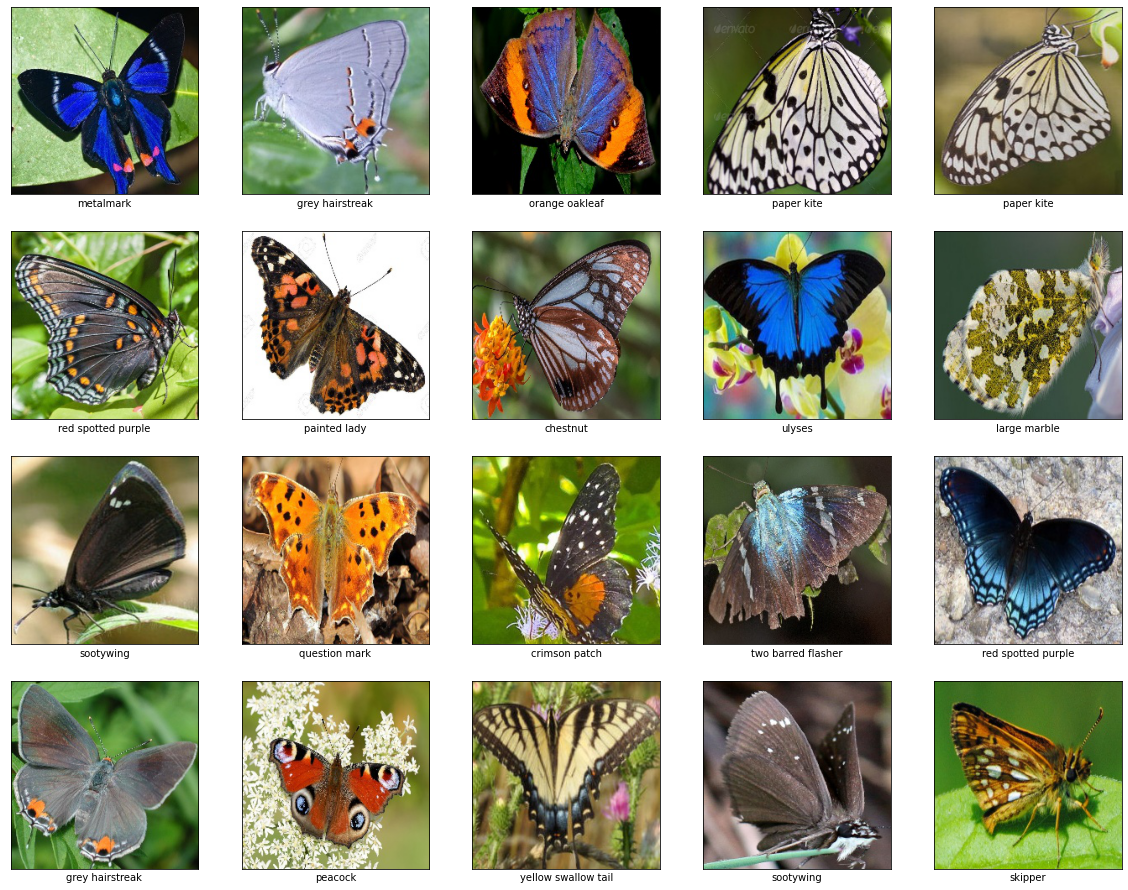

In [ ]:
plt.figure(figsize=(20,20))
ramlist = []
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    ramlist.append(randint(0,len(train)))
    plt.grid(False)
    plt.imshow(train[ramlist[i]])
    plt.xlabel(labels_train[ramlist[i]])
plt.show()

## Redimensionamiento de las imágenes

In [ ]:
# Rezise de las imágenes

# P: Nuevo número de pixeles al cuadrado (P^2 = PXP) de las imagenes (1-224)
P = 112

# R: Reescalado de las imagenes en porcentaje (0-1)
# R = 0.125

auxtrain = []
for img in train:
  #auxtrain.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxtrain.append(resize(img, (P, P), anti_aliasing=True))
train.clear()
train = auxtrain.copy()

auxtest = []
for img in test:
  #auxtest.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxtest.append(resize(img, (P, P), anti_aliasing=True))
test.clear()
test = auxtest.copy()

auxvalid = []
for img in valid:
  #auxvalid.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxvalid.append(resize(img, (P, P), anti_aliasing=True))
valid.clear()
valid = auxvalid.copy()

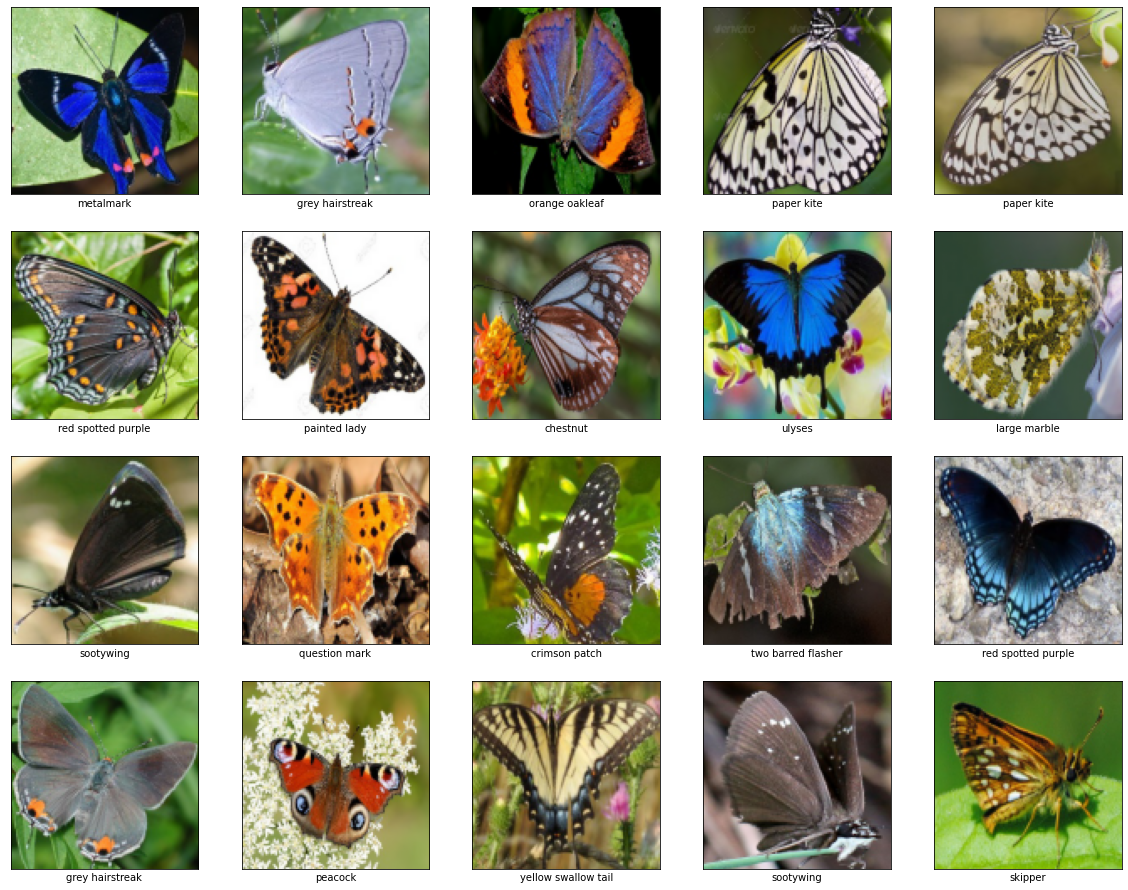

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[ramlist[i]])
    plt.xlabel(labels_train[ramlist[i]])
plt.show()

## Categorización de las clases

In [ ]:
# Vuelve las clases categóricas

label_train_cat=[]
for i in labels_train:
  label_train_cat.append(claseslist.index(i))
label_train_cat=np.array(label_train_cat)

label_test_cat=[]
for i in labels_test:
  label_test_cat.append(claseslist.index(i))
label_test_cat=np.array(label_test_cat)

label_valid_cat=[]
for i in labels_valid:
  label_valid_cat.append(claseslist.index(i))
label_valid_cat=np.array(label_valid_cat)


In [ ]:
# Pasa de list a np.array

train=np.array(train)
test=np.array(test)
valid=np.array(valid)

#Convertir a flotante y normalizar para que aprenda mejor la red
# train = train.astype('float32') / 255
# test = test.astype('float32') / 255
# valid = valid.astype('float32') / 255

# 'Concatena' los datasets test y valid en test
test = np.append(test, valid,axis=0)
label_test_cat = np.append(label_test_cat,label_valid_cat, axis=0)

print(len(test))
print(len(label_test_cat))

500
500


## Definición del módelo

Se define un modelo con 4 capas convoluciones con función de activación relu, y se definen los Kernels como una potencia a la 2 a partir de 2^5 (siempre creciente) 
luego se define una capa de dropout al 0.5, y una capa de vuelve la imagen de una sola dimensión, para finalizar con dos capas densas, una Relu nuevamente y una softmax que nos dará el porcentaje de pertenencia de una imagen a las 50 clases.

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), input_shape=(P, P, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(N, activation="softmax")
    
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Entrenamiento del módelo

In [ ]:
history=model.fit(train, label_train_cat, epochs=20)  

Epoch 1/20
155/155 [==============================] - 37s 41ms/step - loss: 2.9174 - accuracy: 0.2266
Epoch 2/20
155/155 [==============================] - 6s 39ms/step - loss: 1.6283 - accuracy: 0.5318
Epoch 3/20
155/155 [==============================] - 6s 39ms/step - loss: 1.0994 - accuracy: 0.6741
Epoch 4/20
155/155 [==============================] - 6s 40ms/step - loss: 0.8829 - accuracy: 0.7245
Epoch 5/20
155/155 [==============================] - 6s 39ms/step - loss: 0.6210 - accuracy: 0.8008
Epoch 6/20
155/155 [==============================] - 6s 40ms/step - loss: 0.4550 - accuracy: 0.8531
Epoch 7/20
155/155 [==============================] - 6s 39ms/step - loss: 0.3510 - accuracy: 0.8884
Epoch 8/20
155/155 [==============================] - 6s 39ms/step - loss: 0.2674 - accuracy: 0.9150
Epoch 9/20
155/155 [==============================] - 6s 39ms/step - loss: 0.2132 - accuracy: 0.9326
Epoch 10/20
155/155 [==============================] - 6s 39ms/step - loss: 0.2026 - accur

## Predicciones

In [ ]:
test_loss, test_acc = model.evaluate(test, label_test_cat)

print('Test accuracy:', test_acc)

16/16 [==============================] - 1s 29ms/step - loss: 0.9950 - accuracy: 0.8140
Test accuracy: 0.8140000104904175


In [ ]:
predictions = model.predict(test)
pruebas = [randint(0,len(predictions)-1) for i in range(20)]
a=[]
b=[]
c=[]
for i in pruebas:
  a.append(claseslist[np.argmax(predictions[i])])
  b.append(claseslist[label_test_cat[i]])
  c.append(claseslist[np.argmax(predictions[i])]==claseslist[label_test_cat[i]])

pd.DataFrame(list(zip(a,b,c)), columns=['Predicción','Valor real','Comparación'])

Predicción           Valor real  Comparación
0                 julia                julia         True
1       grey hairstreak      grey hairstreak         True
2               viceroy              viceroy         True
3   silver spot skipper  silver spot skipper         True
4            paper kite           paper kite         True
5        banded peacock       banded peacock         True
6       orchard swallow      orchard swallow         True
7        scarce swallow       scarce swallow         True
8           copper tail          copper tail         True
9          great eggfly         great eggfly         True
10     pipevine swallow     pipevine swallow         True
11         large marble         large marble         True
12                julia     black hairstreak        False
13   two barred flasher   two barred flasher         True
14  silver spot skipper  silver spot skipper         True
15           paper kite   clodius parnassian        False
16                an 88                an 88         True
17          gold banded          gold banded         True
18         painted lady         painted lady         True
19               adonis               adonis         True

## Métricas de Desempeño

In [ ]:
decoded_predictions = predictions.argmax(axis=1)

# Cálculo del reporte de clasificación

print(f'Reporte de clasificación:')
print(classification_report(label_test_cat,
                            decoded_predictions))
 


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.88      0.70      0.78        10
           2       1.00      0.90      0.95        10
           3       0.69      0.90      0.78        10
           4       0.55      0.60      0.57        10
           5       0.88      0.70      0.78        10
           6       0.89      0.80      0.84        10
           7       0.82      0.90      0.86        10
           8       0.83      0.50      0.62        10
           9       0.83      0.50      0.62        10
          10       0.55      0.60      0.57        10
          11       1.00      0.40      0.57        10
          12       1.00      1.00      1.00        10
          13       0.77      1.00      0.87        10
          14       0.75      0.90      0.82        10
          15       0.82      0.90      0.86        10
          16       0.75      0.90      0.82        10
 

### Calculo de exactitud (Accuracy)

In [ ]:
# Cálculo de accuracy
print(f'Exactitud (accuracy): {accuracy_score(label_test_cat, decoded_predictions)}')

Exactitud (accuracy): 0.814


### Cálculo de precisión

In [ ]:
# Cálculo de precisión
print(f'Precisión (micro): {precision_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'Precisión (macro): {precision_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'Precisión (weighted): {precision_score(label_test_cat, decoded_predictions, average="weighted")}')
 
print(f'Precisión por clase:')
print('----')
precision_score_per_class = precision_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), precision_score_per_class):
    print(f'\t - Precisión para "{claseslist[label]}": {score}')
print('----')

Precisión (micro): 0.814
Precisión (macro): 0.8311388056388057
Precisión (weighted): 0.8311388056388057
Precisión por clase:
----
	 - Precisión para "adonis": 0.75
	 - Precisión para "american snoot": 0.875
	 - Precisión para "an 88": 1.0
	 - Precisión para "banded peacock": 0.6923076923076923
	 - Precisión para "beckers white": 0.5454545454545454
	 - Precisión para "black hairstreak": 0.875
	 - Precisión para "cabbage white": 0.8888888888888888
	 - Precisión para "chestnut": 0.8181818181818182
	 - Precisión para "clodius parnassian": 0.8333333333333334
	 - Precisión para "clouded sulphur": 0.8333333333333334
	 - Precisión para "copper tail": 0.5454545454545454
	 - Precisión para "crecent": 1.0
	 - Precisión para "crimson patch": 1.0
	 - Precisión para "eastern coma": 0.7692307692307693
	 - Precisión para "gold banded": 0.75
	 - Precisión para "great eggfly": 0.8181818181818182
	 - Precisión para "grey hairstreak": 0.75
	 - Precisión para "indra swallow": 1.0
	 - Precisión para "julia"

### Cálculo de sensibilidad (Recall)

In [ ]:
# Cálculo de recall
print(f'Recall (micro): {recall_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'Recall (macro): {recall_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'Recall (weighted): {recall_score(label_test_cat, decoded_predictions, average="weighted")}')
 
print(f'Recall por clase:')
print('----')
recall_score_per_class = recall_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), recall_score_per_class):
    print(f'\t - Recall  para "{claseslist[label]}": {score}')
print('----')
 

Recall (micro): 0.814
Recall (macro): 0.8140000000000001
Recall (weighted): 0.814
Recall por clase:
----
	 - Recall  para "adonis": 0.9
	 - Recall  para "american snoot": 0.7
	 - Recall  para "an 88": 0.9
	 - Recall  para "banded peacock": 0.9
	 - Recall  para "beckers white": 0.6
	 - Recall  para "black hairstreak": 0.7
	 - Recall  para "cabbage white": 0.8
	 - Recall  para "chestnut": 0.9
	 - Recall  para "clodius parnassian": 0.5
	 - Recall  para "clouded sulphur": 0.5
	 - Recall  para "copper tail": 0.6
	 - Recall  para "crecent": 0.4
	 - Recall  para "crimson patch": 1.0
	 - Recall  para "eastern coma": 1.0
	 - Recall  para "gold banded": 0.9
	 - Recall  para "great eggfly": 0.9
	 - Recall  para "grey hairstreak": 0.9
	 - Recall  para "indra swallow": 0.7
	 - Recall  para "julia": 0.8
	 - Recall  para "large marble": 0.8
	 - Recall  para "malachite": 0.8
	 - Recall  para "mangrove skipper": 0.8
	 - Recall  para "metalmark": 0.9
	 - Recall  para "monarch": 0.4
	 - Recall  para "mor

### Cálculo del f1-score

In [ ]:
# Cálculo de F1
print(f'F1-micro: {f1_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'F1-macro: {f1_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'F1-weighted: {f1_score(label_test_cat, decoded_predictions, average="weighted")}')
 
print(f'F1 por clase:')
print('----')
f1_score_per_class = f1_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), f1_score_per_class):
    print(f'\t - F1 para "{claseslist[label]}": {score}')
print('----')

F1-micro: 0.8140000000000001
F1-macro: 0.8091614689284632
F1-weighted: 0.809161468928463
F1 por clase:
----
	 - F1 para "adonis": 0.8181818181818182
	 - F1 para "american snoot": 0.7777777777777777
	 - F1 para "an 88": 0.9473684210526316
	 - F1 para "banded peacock": 0.7826086956521738
	 - F1 para "beckers white": 0.5714285714285713
	 - F1 para "black hairstreak": 0.7777777777777777
	 - F1 para "cabbage white": 0.8421052631578948
	 - F1 para "chestnut": 0.8571428571428572
	 - F1 para "clodius parnassian": 0.625
	 - F1 para "clouded sulphur": 0.625
	 - F1 para "copper tail": 0.5714285714285713
	 - F1 para "crecent": 0.5714285714285715
	 - F1 para "crimson patch": 1.0
	 - F1 para "eastern coma": 0.8695652173913044
	 - F1 para "gold banded": 0.8181818181818182
	 - F1 para "great eggfly": 0.8571428571428572
	 - F1 para "grey hairstreak": 0.8181818181818182
	 - F1 para "indra swallow": 0.8235294117647058
	 - F1 para "julia": 0.761904761904762
	 - F1 para "large marble": 0.6956521739130435
	

## Matriz de confusión

In [ ]:
#impresion matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(label=title,fontdict={'fontsize': 30, })
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", size=12,color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor verdadero',size=20)
    plt.xlabel('Predicción',size=20)

Confusion matrix, without normalization
[[ 9  0  0 ...  0  0  0]
 [ 0  7  0 ...  1  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  7]]


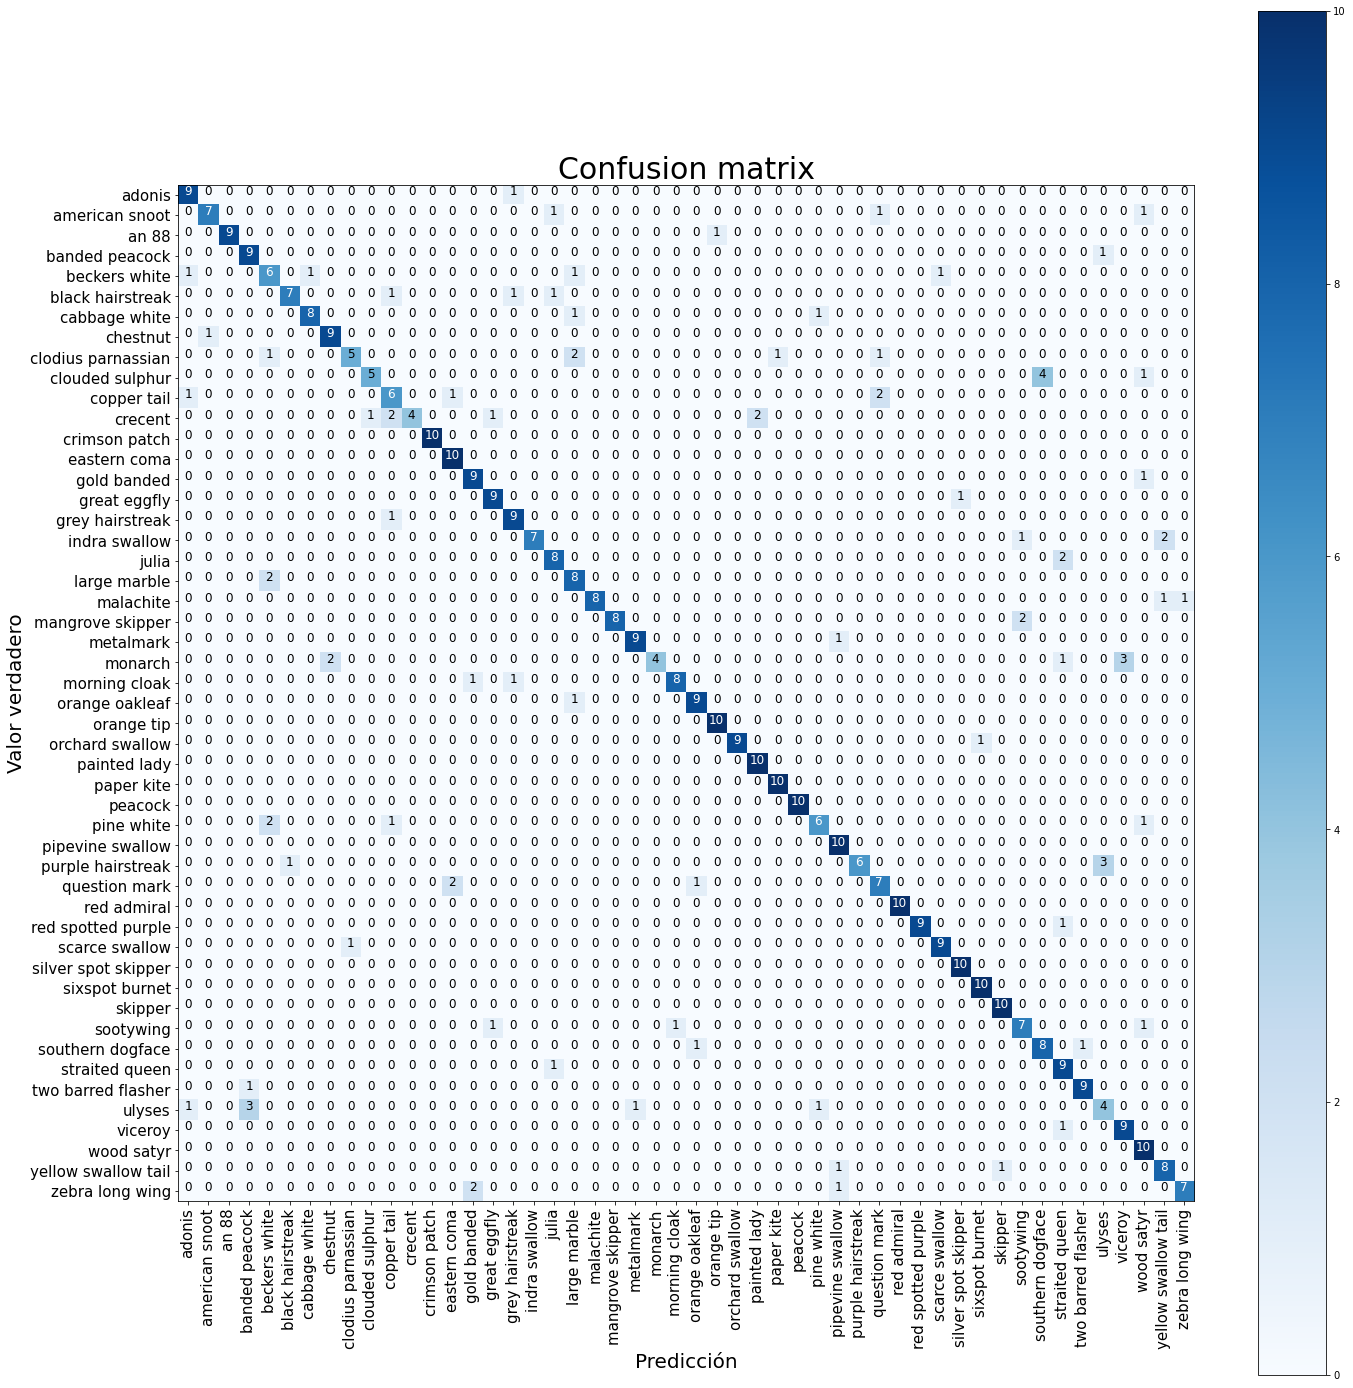

In [ ]:


matrix = confusion_matrix(label_test_cat, decoded_predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(matrix, claseslist)

# Conclusiones.

De la precisión podemos decir que está alrededor de un 80%. Esto significa que aproximadamente el 80% de las mariposas que clasifique el modelo son de la especie que indicó la red neuronal.
Del recall podemos concluir que en la mayoria de ocasiones el modelo predecirá bien 4 de cada 5 especies de mariposas.
Según la exactitud el modelo acierta cerca del 80% de las veces.
Consultando un poco encontramos que la métrica de exactitud no es tan buena, sin embargo podemos ver que la precisión y el recall son muy buenas y son mas precisas, además nuestras clases están bien balanceadas.

Viendo las métricas de exactitud de los algoritmos mostrados en clase y en las prácticas podemos llegar a la conclusión de que nuestra red clasifica de una muy buena manera las mariposas, esto lo explicamos nosotros gracias a el orden tan bueno del dataset, la calidad de las imágenes, además del preprocesamiento de estas y el planteamiento de la red neuronal.


